<a href="https://colab.research.google.com/github/mttbanizi/Bearing_condition_machine-learning/blob/main/2D_CNN_Vibration_Signal_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/0_load_48_KHz/all_faults.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=300

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],28,28,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [ ]:
X.shape

(3279, 28, 28, 1)

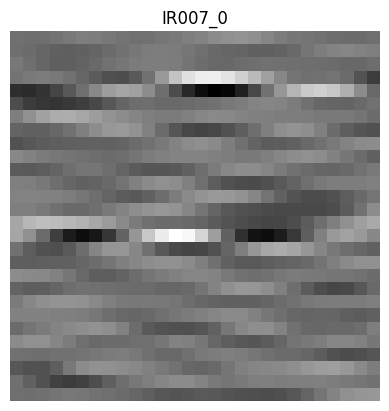

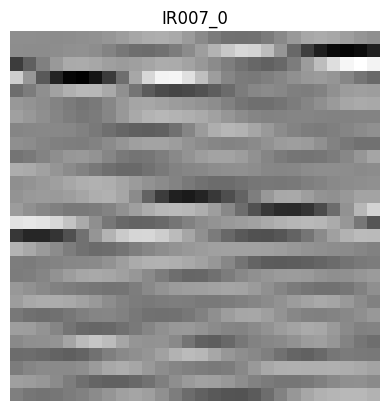

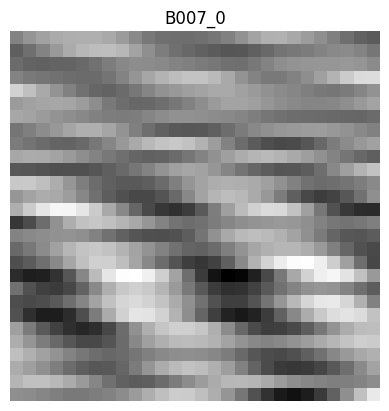

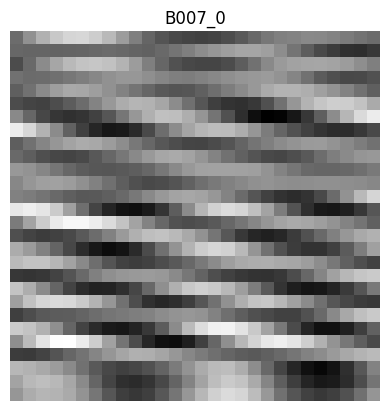

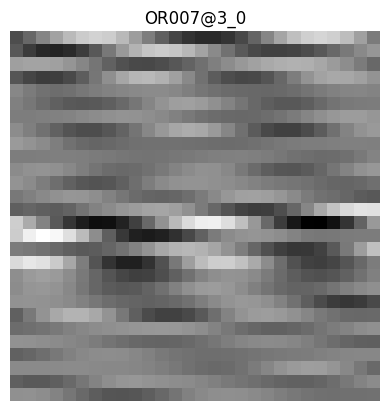

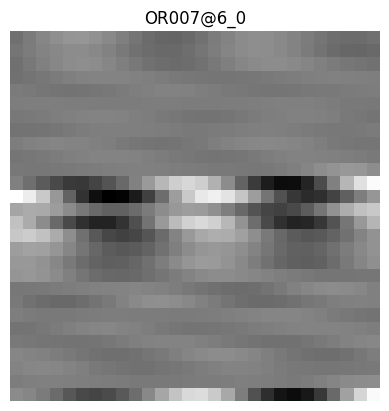

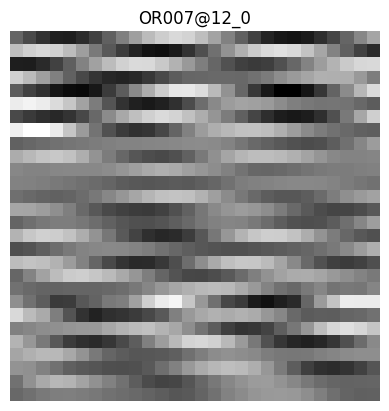

In [ ]:
from matplotlib.pyplot import imread


for idx in range(0,3200,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D



# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = len(df['fault'].unique())

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(X.shape[1],X.shape[2],1),padding='same'))

cnn_model.add(MaxPooling2D((2, 2),strides=(2, 2),padding='same'))

cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))

cnn_model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='same'))

# cnn_model.add(Conv2D(128, (5, 3), activation='relu',padding='same'))

# cnn_model.add(MaxPooling2D(pool_size=(5, 2),strides=(3, 3),padding='same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))

cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
batch_size =200
epochs = 20
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)


Epoch 1/20
12/12 [==============================] - 4s 256ms/step - loss: 1.1804 - accuracy: 0.4187 - val_loss: 0.9246 - val_accuracy: 0.4929
Epoch 2/20
12/12 [==============================] - 3s 222ms/step - loss: 0.8157 - accuracy: 0.6418 - val_loss: 0.6599 - val_accuracy: 0.8587
Epoch 3/20
12/12 [==============================] - 4s 341ms/step - loss: 0.4408 - accuracy: 0.9272 - val_loss: 0.1612 - val_accuracy: 0.9939
Epoch 4/20
12/12 [==============================] - 4s 303ms/step - loss: 0.0687 - accuracy: 0.9965 - val_loss: 0.0200 - val_accuracy: 0.9980
Epoch 5/20
12/12 [==============================] - 3s 231ms/step - loss: 0.0088 - accuracy: 0.9996 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 3s 233ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 0.0060 - val_accuracy: 0.9990
Epoch 7/20
12/12 [==============================] - 3s 234ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9990
Epoch 

31/31 [==============================] - 0s 12ms/step


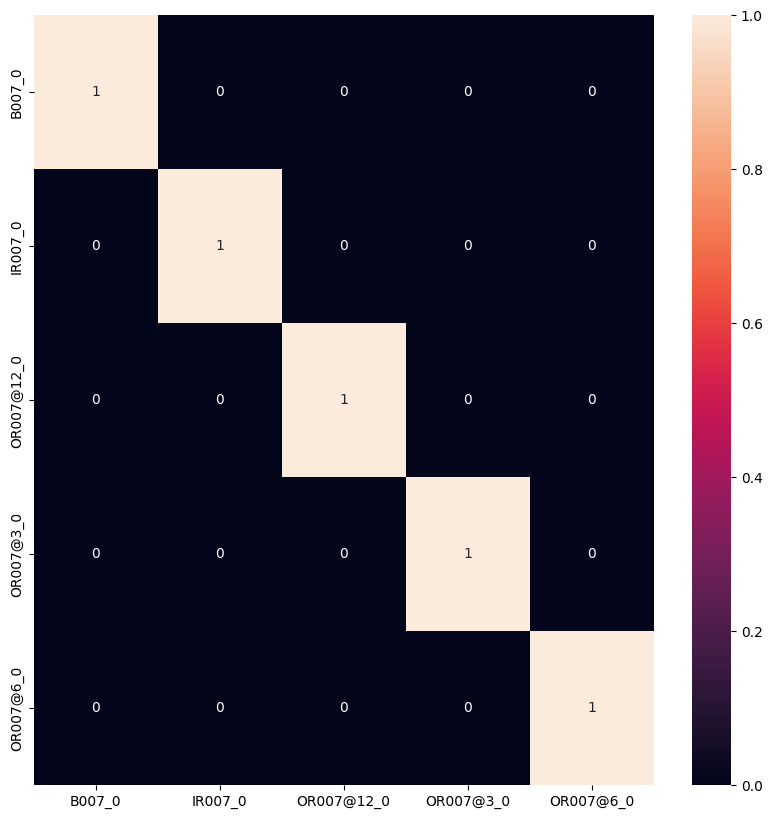

In [ ]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)

72/72 [==============================] - 1s 13ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2295 samples in 0.001s...
[t-SNE] Computed neighbors for 2295 samples in 0.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2295
[t-SNE] Computed conditional probabilities for sample 2000 / 2295
[t-SNE] Computed conditional probabilities for sample 2295 / 2295
[t-SNE] Mean sigma: 1.430787
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.816284
[t-SNE] KL divergence after 300 iterations: 1.290054


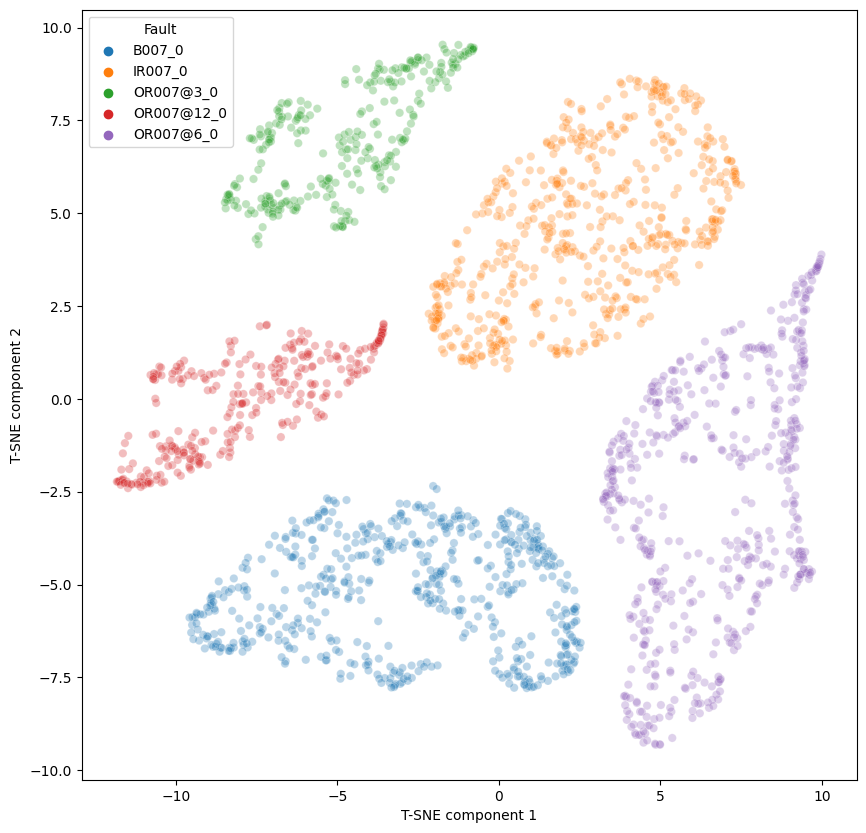

In [ ]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()